# **DICOM preprocessing pipeline**

Required libs:
- pydicom
- gdcm
- dicom2nifti
- dicom-contour
- opencv
- matplotlib
- skimage

## Topics covered:
1. DICOM: understand, read and visualise
2. DICOM-RT: read and visualise
3. DICOM/-RT: prepare for CNN training

In [1]:
%matplotlib inline

import numpy as np # linear algebra
import pydicom
import gdcm
import os
import cv2
import scipy.ndimage
import matplotlib.pyplot as plt
import random
from IPython.display import Image
    

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


In [2]:
# INPUT_FOLDER = '../Datasets/DICOM Native anonymized/'
INPUT_FOLDER = '/media/kamila/System/Users/Kama/Documents/DATASETS/DICOM/DICOM Native anonymized'
LIST_PATIENTS_PATHS = []

## 1. DICOM: understand, read and visualise

### DICOM folder structure

First of all we will inspect the structure of a main folder (INPUT FOLDER). This is how it looks like:

###### Main folder
- patient0_parent_folder
    - patient00_target_folder
        - 0.dcm
        - ...
        - n.dcm
     - patient01_target_folder
         - 0.dcm
         - ...
         - n.dcm
     - ...
     - patient0m_target_folder
- patient1_parent_folder
    - ...
        - ...
- ...
    - ...
        - ...
- patientl_parent_folder
    - ...
        - ...

#### List of patients paths
We need to obtain the list of folder paths, that contain only dicom files.

In [3]:
def get_patient_target_folder(patient_parent_folder):
    patient_target_folder = os.listdir(patient_parent_folder)[0]
    patient_target_folder = patient_parent_folder + '/' + patient_target_folder
    return patient_target_folder

def get_list_patients_paths(input_folder):
    list_patients_paths = []
    for element in os.listdir(input_folder):
        patient_parent_folder = os.path.join(INPUT_FOLDER, element)
        patient_target_folder = get_patient_target_folder(patient_parent_folder)
        patient_target_folder = patient_target_folder + '/'
        list_patients_paths.append(patient_target_folder)
        # print(patient_target_folder)
    return list_patients_paths

LIST_PATIENTS_PATHS = get_list_patients_paths(INPUT_FOLDER)
print(LIST_PATIENTS_PATHS[:1])


['/media/kamila/System/Users/Kama/Documents/DATASETS/DICOM/DICOM Native anonymized/1.2.124.113532.12.10699.12127.20110301.154346.9227917/1.3.12.2.1107.5.1.4.53642.30000011022806271114000017842/']


### Inspect single .dcm file with pydicom

DICOM data is parsed and stored into python objects:
    - Dataset (derived from dict)
    - DataElement
    - Tag
    - Sequence (derived from list)



In order to understad how pydicom works with dicom data, we will inspect an example file and read some basic information.

#### An example dicom file - random choice

In [4]:
example_patient = random.choice(LIST_PATIENTS_PATHS) 
dcm_file = example_patient + '/' + random.choice(os.listdir(example_patient))
dcm_file

'/media/kamila/System/Users/Kama/Documents/DATASETS/DICOM/DICOM Native anonymized/1.2.124.113532.12.10699.12127.20110321.143718.22145985/1.3.12.2.1107.5.1.4.53642.30000011032114095153100000518//1.3.12.2.1107.5.1.4.53642.30000011032114095153100000585.dcm'

##### Load a dicom file as Dataset object

###### Dataset

**Dataset** is a main object in pydicom's object model. **Dataset** class is derived from python's dictionary. It contains **DataElement** instances as values and **Tags** as keys. It corresponds to the DICOM file format structure: the DICOM information within the header is organized as a constant and standardized series of tags. These tags are organized into groups of data elements.


<img src="http://www.ijri.org/articles/2012/22/1/images/IndianJRadiolImaging_2012_22_1_4_95396_u2.jpg" alt="Drawing" style="width: 200px;"/>

In [5]:
ds = pydicom.read_file(dcm_file)
ds


(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL', 'CT_SOM5 SPI']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.12.2.1107.5.1.4.53642.30000011032114095153100000585
(0008, 0020) Study Date                          DA: '20110321'
(0008, 0021) Series Date                         DA: '20110321'
(0008, 0022) Acquisition Date                    DA: '20110321'
(0008, 0023) Content Date                        DA: '20110321'
(0008, 0030) Study Time                          TM: '153934.140000'
(0008, 0031) Series Time                         TM: '154045.906000'
(0008, 0032) Acquisition Time                    TM: '154121.560026'
(0008, 0033) Content Time                        TM: '154121.560026'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CT'
(0008, 0

You can access specific elements by their DICOM keyword or tag number:

In [6]:
ds.PatientName == ds[0x10,0x10].value

True

When using the tag number directly a DataElement instance is returned, so DataElement.value must be used to get the value. 

In [7]:
ds[0x08,0x08].value

['ORIGINAL', 'PRIMARY', 'AXIAL', 'CT_SOM5 SPI']

##### DataElement

The DataElement class is not usually used directly in user code, but is used extensively by Dataset. DataElement is a simple object which stores the following things:

- tag – the element’s tag (as a BaseTag object)
- VR – the element’s Value Representation – a two letter str that describes to the format of the stored value
- VM – the element’s Value Multiplicity as an int. This is automatically determined from the contents of the value.
- value – the element’s actual value. A regular value like a number or string (or list of them if the VM > 1), or a Sequence.

In [8]:
print(ds[0x08,0x60].tag, ds[0x08,0x60].name, ": ", ds[0x08,0x60].value)
print("\tValue Representation: ", ds[0x08,0x60].VR)
print("\tValue Multiplicity: ", ds[0x08,0x60].VM)

(0008, 0060) Modality :  CT
	Value Representation:  CS
	Value Multiplicity:  1


##### Tag

**Tag()** is not generally used directly in user code, as **BaseTags** are automatically created when you assign or read elements using their keywords.

The **BaseTag** class is derived from **int** in Python 3 and **long** in Python 2, so in effect, it is just a number with some extra behaviour:

- **Tag()** is used to create instances of **BaseTag** and enforces that the DICOM tag fits in the expected 4-byte (group,element)

- A **BaseTag** instance can be created from an int or a tuple containing the (group,element), or from the DICOM keyword:
- BaseTag.group and BaseTag.elem to return the group and element portions of the tag.

- The BaseTag.is_private property checks whether the tag represents a private tag (i.e. if group number is odd).

In [9]:
# source: https://pydicom.github.io/pydicom/stable/old/base_element.html
from pydicom.tag import Tag
t1 = Tag(0x00100010) # int
t2 = Tag(0x10,0x10) # tuple
t3 = Tag((0x10, 0x10)) # tuple
t4 = Tag("PatientName") # corresponding name
print(type(t4))
# all of these are equivalent
t1==t2, t1==t3, t1==t4
#t1.is_private

<class 'pydicom.tag.BaseTag'>


(True, True, True)

In [10]:
t = Tag(0x00200013) # Instance Number
print(ds[t].tag, ds[t].name, ": ", ds[t].value)
print("\tValue Representation: ", ds[t].VR)
print("\tValue Multiplicity: ", ds[t].VM)


(0020, 0013) Instance Number :  67
	Value Representation:  IS
	Value Multiplicity:  1


#### Inspect pixel information in DICOM file 


#### Display a single scan with Dataset.pixel_array and Matplotlib

Pydicom is mainly concerned with getting at the DICOM data elements in files, but it is often desirable to view pixel data as an image. 
Matplotlib can take 2D image information from Dataset.pixel_array and display it. Here is an example:

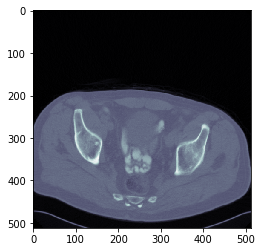

In [11]:
plt.imshow(ds.pixel_array, cmap=plt.cm.bone) 

#### How pixel information is stored in DICOM

In order to obtain full information about image in DICOM file, we need 2 things:
1) Pixel Data Attribute (7FE0,0010)
2) Image Pixel Module (0028, xxxx)

The Pixel Data Element (7FE0,0010) along with additional Data Elements, specified as Attributes of the Image Information Entities shall be used to describe the way in which the Pixel Data is encoded and shall be interpreted. 

#####  Pixel Data Attribute (7FE0,0010) (PixelData) 

The Pixel Data Element (7FE0,0010) has a VR of OW or OB. 

- OB (other byte) means that every value in the data element is a byte
- OW (other word) means that every sample is stored in two bytes

The only difference between OW and OB being that OB, a string of bytes, shall be unaffected by Byte Ordering.

PixelData is often not immediately useful as data may be stored in a variety of different ways:

- The pixel values may be signed or unsigned integers, or floats
- There may be multiple image frames
- There may be multiple planes per frame (i.e. RGB) and the order of the pixels may be different
- The image data may be encoded using one of the available compression standards (1.2.840.10008.1.2.4.50 JPEG Baseline, 1.2.840.10008.1.2.5 RLE Lossless, etc). Encoded image data will also be encapsulated and each encapsulated image frame may be broken up into one or more fragments.


In [12]:
print(ds[0x7FE00010].VR)
ds.PixelData[:100]

OB


b'\xfe\xff\x00\xe0\x00\x00\x00\x00\xfe\xff\x00\xe0`?\x03\x00\xff\xd8\xff\xe0\x00\x0fLJIF\x00\x01\x00\x00\x00\x00\x00\x00\x00\xff\xfe\x00\x16MITRA_DICOM_STANDARD\xff\xc4\x00\x1f\x00\x00\x03\x00\x03\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x03\x04\x05\x01\x02\x06\x00\x07\x08\t\n\x10\xff\xc3\x00\x0b\x10\x02\x00\x02'

##### Image Pixel Module (0028, xxxx)

This module with the tags starting with 0028 describes the Image Pixel Module. which is responsible for describing how to read the pixels.

###### Rows and columns
Rows (0028,0010) and Columns (0028,0011) define the size of the image.

###### Samples Per Pixel
Samples per pixel (0028,0002)define the number of color channels. In grayscale images like CT and MR it is set to 1 for the single grayscale channel and for color images like in our case it is set to 3 for the three color channels Red, Green and Blue.

###### Photometric Interpratation
The photometric interpratation (0028,0004) element defines what does every color channel hold. E.g. "RGB" means the first channel is Red, the second is Green and the third is Blue.

###### Planar configuration
Planar configuration (0028,0006) defines how the color channels are arranged in the pixel data buffer. Exists only for images with Samples Per Pixel > 1.

###### Bits allocated
Bits Allocated (0028,0100) defines how much space is allocated in the buffer for every sample in bits. E.g. 24 bit RGB image = 8 bits/channel.

###### Bits stored
Bits Stored (0028,0101) defines how many of the bits allocated are actually used. If value of sample is between 0 and 255, all the 8 bits are used so bits stored is 8. For CT images, where each sample value is between 0 and 4095, bits stored is 12 (2^12=4096).

###### High Bit
High Bit (0028,0102) defines how the bits stored are aligned inside the bits allocated. It is the bit number (the first bit is bit 0) of the last bit used.

In [13]:
image_pixel_tags = [(0x00280010), (0x00280011), (0x00280004), (0x00280100), 
                    (0x00280101),(0x00280102)]
for t in image_pixel_tags:
    print(ds[t].tag, ds[t].name, ": ", ds[t].value)
    print("\tValue Representation: ", ds[t].VR)
    print("\tValue Multiplicity: ", ds[t].VM)
    print("\n\n")

(0028, 0010) Rows :  512
	Value Representation:  US
	Value Multiplicity:  1



(0028, 0011) Columns :  512
	Value Representation:  US
	Value Multiplicity:  1



(0028, 0004) Photometric Interpretation :  MONOCHROME2
	Value Representation:  CS
	Value Multiplicity:  1



(0028, 0100) Bits Allocated :  16
	Value Representation:  US
	Value Multiplicity:  1



(0028, 0101) Bits Stored :  12
	Value Representation:  US
	Value Multiplicity:  1



(0028, 0102) High Bit :  11
	Value Representation:  US
	Value Multiplicity:  1





#####  Pixel_array

Because of the complexity in interpreting the pixel data, pydicom provides an easy way to get it in a convenient form: Dataset.pixel_array, what was presented in section "Display a single scan with Dataset.pixel_array and Matplotlib". Dataset.pixel_array requires NumPy. Dataset.pixel_array returns a numpy.ndarray containing the pixel data:

(512, 512)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


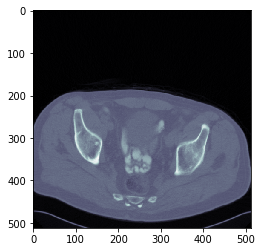

In [14]:
print(ds.pixel_array.shape)
print(ds.pixel_array)

plt.imshow(ds.pixel_array, cmap=plt.cm.bone) 

### Working with entire scan (CT scan)

#### Display all images

In case of CT scans, in order to inspect a full medical examination, there is a need to load all images. They can be then display as a 3D object. In order to obtain correct 3D view, scans images should be loaded in correct order. This information is stored in InstanceNumber attribute.



The Image Plane Module defines the direction of the image with respect to the patient body and mapping between the pixels in the image plane and the patient. It also gives the dimensions of the pixels (or voxels if you like) in mm. Attributes that describes Image Plane are:

###### Pixel Spacing
Pixel Spacing is the physical distance in the patient between the center of each pixel, specified by 2 numeric values: 1) adjacent row spacing 2) adjacent column spacing (mm)

![title](imgs/PS3.3_10.7.1.3-1.svg)


###### Slice Spacing
Corresponding value to Pixel Spacing in Z direction. Can be calculated from difference in the Slice Location in 2 adjacent slices.


**Pixel Spacing and Slice Spacing should be the same for one scan**

###### Slice Location 
Relative position of the image plane expressed in mm. Can be also calculated using Image Position Patient.


###### Image Position (Patient)
Image Position Patient - x, y and z coordinates of the upper left hand corner (center of the first voxel transmitted)


###### Image Orientation (Patient)
The direction cosines of the first row and the first column with respect to the patient.


###### Slice Thickness
Nominal slice thickness (mm). Can be interpreted as collimator width.





In [15]:
image_pixel_tags = [(0x00280030), (0x00200037), (0x00200032), (0x00180050), 
                    (0x00201041)]
for t in image_pixel_tags:
    print(ds[t].tag, ds[t].name, ": ", ds[t].value)
    print("\tValue Representation: ", ds[t].VR)
    print("\tValue Multiplicity: ", ds[t].VM)
    print("\n\n")
    


(0028, 0030) Pixel Spacing :  [0.716796875, 0.716796875]
	Value Representation:  DS
	Value Multiplicity:  2



(0020, 0037) Image Orientation (Patient) :  [1, 0, 0, 0, 1, 0]
	Value Representation:  DS
	Value Multiplicity:  6



(0020, 0032) Image Position (Patient) :  [-187.1416015625, -373.1416015625, -381]
	Value Representation:  DS
	Value Multiplicity:  3



(0018, 0050) Slice Thickness :  5
	Value Representation:  DS
	Value Multiplicity:  1



(0020, 1041) Slice Location :  381
	Value Representation:  DS
	Value Multiplicity:  1





In [16]:
# Load the scans in given folder path
def load_scan(path):
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path) if s.endswith('dcm')]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    
    if not "SliceThickness" in ds:
        try:
            slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
        except:
            slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)

        for s in slices:
            print(s.SliceThickness)
            s.SliceThickness = slice_thickness
        
    return slices

#### Converting raw pixel values to Hounsfield Units

Tags 0028,1052 (Rescale Intercept) and 0028, 1053 (Rescale Slope) are the paramaters which define the linear rescaling from raw pixel values inthe DICOM field to Hounsfield Units. 

The Hounsfield scale is a quantitative scale for describing radiodensity.



<img src="https://www.researchgate.net/publication/327863426/figure/tbl1/AS:674762674147338@1537887366780/Hounsfield-scale-table.png" alt="Drawing" style="width: 400px;"/>

In [19]:
# source: https://www.kaggle.com/gzuidhof/data-science-bowl-2017/full-preprocessing-tutorial
def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

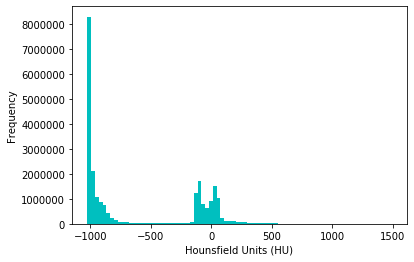

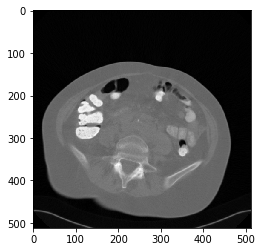

In [20]:
first_patient_path = LIST_PATIENTS_PATHS[0]
first_patient = load_scan(first_patient_path)
first_patient_pixels = get_pixels_hu(first_patient)
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle
plt.imshow(first_patient_pixels[80], cmap=plt.cm.gray)
plt.show()

### Information about geometry from DICOM

<img src="https://www.slicer.org/w/img_auth.php/2/22/Coordinate_sytems.png" alt="Drawing" style="width: 600px;"/>


### Build a 3D object from 2D images with visualisation

In [22]:
def readDICOM3D(DICOM_DIR,verbose = False):

    dicomFiles = [file for file in os.listdir(DICOM_DIR) if file.endswith('dcm')]
    dicoms = []
    # dicoms = load_scan(dicomFiles)
    for file in dicomFiles:
        ds = pydicom.dcmread(DICOM_DIR+file)
        dicoms.append((DICOM_DIR+file,int(ds[0x0020,0x0013].value)))
    dicoms = sorted(dicoms, key=lambda x: x[1])

    im3D = []
    for d in dicoms:
        ds = pydicom.dcmread(d[0])
        im3D.append(ds.pixel_array)

    im3D = np.asarray(im3D,dtype=np.int16)
    im3D = np.swapaxes(im3D,0,1)
    im3D = np.swapaxes(im3D,1,2)

    if verbose==True:
        print(im3D.shape)                 

        for s in range(0,im3D.shape[0]):
            fig = plt.figure(figsize=(5, 5))
            plt.imshow(im3D[s], cmap = 'gray')
            plt.show()

    return im3D

In [23]:
im3D = readDICOM3D(first_patient_path)

In [24]:
im3D.shape

(512, 512, 90)

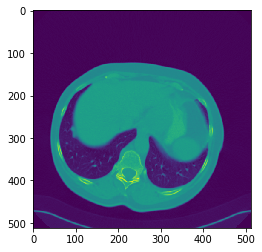

In [31]:
# plt.imshow(im3D[:, :, im3D.shape[2]//2])
# # plt.imshow(im3D[:, im3D.shape[1]//2, :])
# # plt.imshow(im3D[im3D.shape[0]//2, :, :].T)
# plt.show()


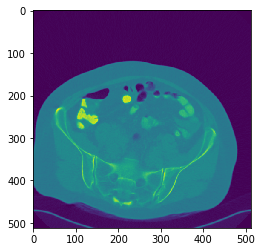

In [76]:
plt.imshow(im3D[:, :, 89])

In [77]:
def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image
#     p = image.transpose(2,1,0)
    p = p[:,:,::-1]
    
    verts, faces = measure.marching_cubes_classic(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

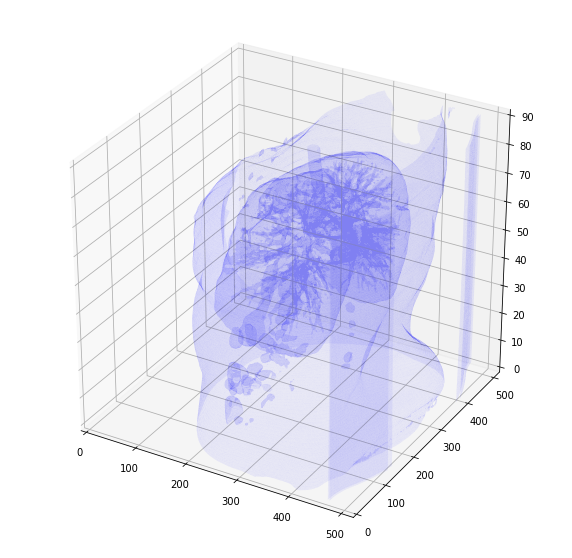

In [78]:
plot_3d(im3D, 400)

### Resampling and normalization

#### Resampling

In order to process data by CNN they should have uniform size. 

A scan may have a pixel spacing of [2.5, 0.5, 0.5], which means that the distance between slices is 2.5 millimeters. For a different scan this may be [1.5, 0.725, 0.725], this can be problematic for automatic analysis (e.g. using CNN).
A common method of dealing with this is resampling the full dataset to a certain isotropic resolution. If we choose to resample everything to 1mm1mm1mm pixels we can use 3D convnets without worrying about learning zoom/slice thickness invariance.


In [30]:
for patient_path in LIST_PATIENTS_PATHS[:30]:
    slices = load_scan(patient_path)
    print(len(slices), slices[0].pixel_array.shape, slices[0].SliceThickness, slices[0].PixelSpacing)

90 (512, 512) 5 [0.744140625, 0.744140625]
90 (512, 512) 5 [0.716796875, 0.716796875]
53 (512, 512) 5 [0.701171875, 0.701171875]
51 (512, 512) 5 [0.658203125, 0.658203125]
34 (512, 512) 5 [0.681640625, 0.681640625]
70 (512, 512) 5 [0.9765625, 0.9765625]
87 (512, 512) 5 [0.6015625, 0.6015625]
95 (512, 512) 5 [0.765625, 0.765625]
82 (512, 512) 5 [0.73046875, 0.73046875]
84 (512, 512) 5 [0.865234375, 0.865234375]
99 (512, 512) 5 [0.92578125, 0.92578125]
55 (512, 512) 5 [0.75390625, 0.75390625]
89 (512, 512) 5 [0.771484375, 0.771484375]
61 (512, 512) 5 [0.658203125, 0.658203125]
64 (512, 512) 5 [0.73046875, 0.73046875]
55 (512, 512) 5 [0.78125, 0.78125]
54 (512, 512) 5 [0.826171875, 0.826171875]
49 (512, 512) 5 [0.68359375, 0.68359375]
73 (512, 512) 5 [0.7890625, 0.7890625]
58 (512, 512) 5.0 [0.702, 0.702]
126 (512, 512) 5.0 [0.662, 0.662]
65 (512, 512) 5.0 [0.831, 0.831]
58 (512, 512) 5.0 [0.660, 0.660]
70 (512, 512) 3 [0.73046875, 0.73046875]
132 (512, 512) 3 [0.607421875, 0.607421875]
1

In [33]:
# source: https://www.kaggle.com/gzuidhof/data-science-bowl-2017/full-preprocessing-tutorial
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
#     spacing = map(float, ([scan[0].SliceThickness] + scan[0].PixelSpacing))
#     spacing = np.array(list(spacing))
    spacing = list(scan[0].PixelSpacing)
    spacing.append(scan[0].SliceThickness)
    spacing = [float(element) for element in spacing]
    spacing = np.array(spacing)
    
    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
#     image.interpolation.zoom(image, real_resize_factor)
    
    return image, new_spacing

##### Example patient - resize and visualize

In [38]:
first_patient = load_scan(first_patient_path)
first_patient_pixels = readDICOM3D(example_patient)

pix_resampled, spacing = resample(first_patient_pixels, first_patient, [1,1,1])
print("Shape before resampling\t", first_patient_pixels.shape)
print("Shape after resampling\t", pix_resampled.shape, spacing)

Shape before resampling	 (512, 512, 90)
Shape after resampling	 (381, 381, 450) [1. 1. 1.]


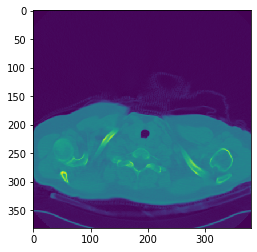

In [39]:
plt.imshow(pix_resampled[:, :, 0])

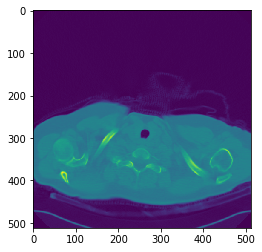

In [41]:
plt.imshow(first_patient_pixels[:, :, 0])

##### Resampling - show results

In [37]:
for patient_path in LIST_PATIENTS_PATHS[:8]:
    slices = load_scan(patient_path)
    pixels = readDICOM3D(patient_path)
    pix_resampled, spacing = resample(pixels, slices, [1,1,1])
    print(pix_resampled.shape)

(381, 381, 450)
(367, 367, 450)
(359, 359, 265)
(337, 337, 255)
(349, 349, 170)
(500, 500, 350)
(308, 308, 435)
(392, 392, 475)


#### Normalization

Our values currently range from -1024 to around 2000. Anything above 400 is not interesting to us, as these are simply bones with different radiodensity. A commonly used set of thresholds normalize between are -1000 and 400.

In [ ]:
MIN_BOUND = -1000.0
MAX_BOUND = 400.0
    
def normalize(image):
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image>1] = 1.
    image[image<0] = 0.
    return image


PIXEL_MEAN = 0.25

def zero_center(image):
    image = image - PIXEL_MEAN
    return image

## 2. DICOM-RT: read and visualise


Contours drawn for radiotherapy are saved as DICOM RT Structure Set (“RT” stands for radiotherapy.) in DICOM Standard, and usually as a single file. You can locate this file among CT or MRI data sets quite reliably, by traversing recursively through the directories and looking for MODALITY of “RTSTRUCT”.

The contours are saved as 2D polygons slice by slice under the Contour Data (3006,0050) tag, which species the data format as:

Sequence of (x,y,z) triplets defining a contour in the patient based coordinate system described in Section C.7.6.2.1.1 (mm). See Section C.8.8.6.1 and Section C.8.8.6.3.

### Change file names

U single file. You can locate this file among CT or MRI data sets. In order to match ... there are 2 possibilities:


In order to simplify the process of matching we change the filenames od DICOM files.



In [110]:
import os

dioms_folder = '../../Team-NET/data/new/HEAD-NECK-RADIOMICS-HN1/HN1004/04-03-2019-CT-25477/54147/'


# old_file = os.path.join("directory", "a.txt")
# new_file = os.path.join("directory", "b.kml")
# os.rename(old_file, new_file)

for dcm_file in os.listdir(dioms_folder):
    dicom_name_full = os.path.join(dioms_folder, dcm_file)
    ds = pydicom.read_file(dicom_name_full)
    new_name = ds[0x08,0x18].value + '.dcm'
    new_name_full = os.path.join(dioms_folder, new_name)
    os.rename(dicom_name_full, new_name_full)

### Read Contours

In [112]:
def showOpencvImage(image, isGray=False):
    fig = plt.figure(figsize=(15, 15))
    plt.imshow(image, cmap = 'gray')
#    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()

['AccessionNumber', 'ApprovalStatus', 'DeidentificationMethod', 'DeidentificationMethodCodeSequence', 'InstanceCreationDate', 'InstanceCreationTime', 'InstanceNumber', 'LongitudinalTemporalInformationModified', 'Manufacturer', 'ManufacturerModelName', 'Modality', 'PatientBirthDate', 'PatientComments', 'PatientID', 'PatientIdentityRemoved', 'PatientName', 'PatientSex', 'ROIContourSequence', 'RTROIObservationsSequence', 'ReferencedFrameOfReferenceSequence', 'ReferringPhysicianName', 'SOPClassUID', 'SOPInstanceUID', 'SeriesInstanceUID', 'SeriesNumber', 'SoftwareVersions', 'SpecificCharacterSet', 'StructureSetDate', 'StructureSetLabel', 'StructureSetROISequence', 'StructureSetTime', 'StudyDate', 'StudyDescription', 'StudyID', 'StudyInstanceUID', 'StudyTime']
1.2.840.10008.5.1.4.1.1.481.3


Structures len =  12
ROIs len =  12


35 35


(3006, 0022) ROI Number                          IS: "35"
(3006, 0024) Referenced Frame of Reference UID   UI: 1.3.6.1.4.1.40744.29.2076243194401282054364378

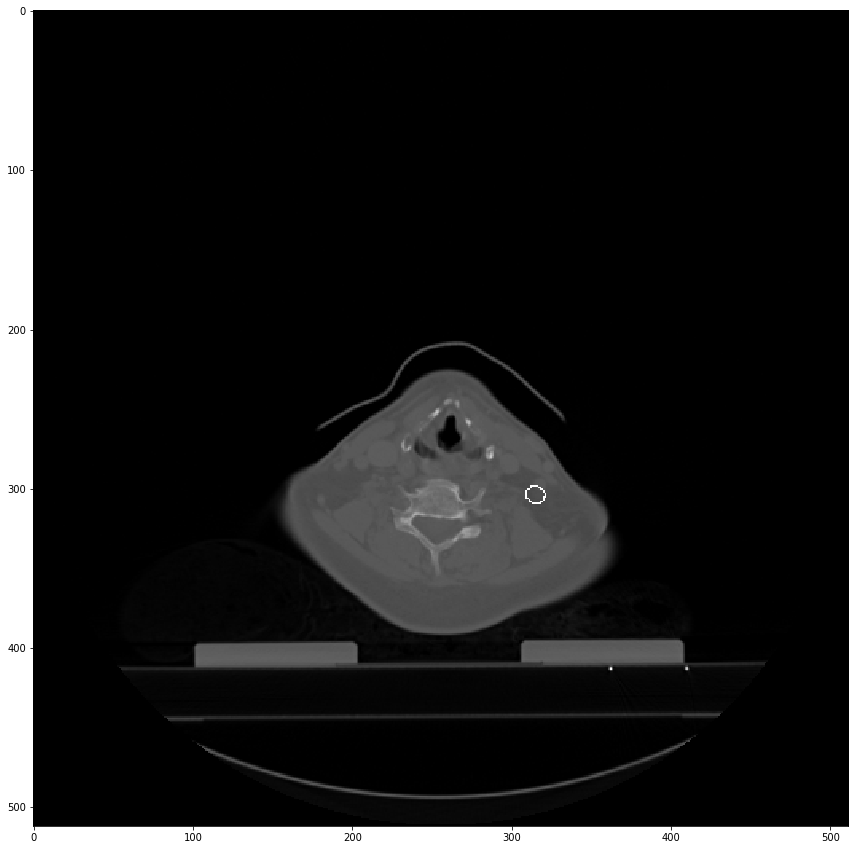

In [116]:
#Read RT Struct
# https://dicom.innolitics.com/ciods/ct-image/image-plane/00200037
# https://dicom.innolitics.com/ciods/rt-structure-set/roi-contour/30060039/30060040/30060050


path = '../../Team-NET/data/new/HEAD-NECK-RADIOMICS-HN1/HN1004/04-03-2019-CT-25477/54147/'
rt_struct_file = '../../Team-NET/data/new/HEAD-NECK-RADIOMICS-HN1/HN1004/04-03-2019-CT-25477/54147/1-1.dcm'


ds = pydicom.dcmread(rt_struct_file)

print(ds.dir())
print(ds.SOPClassUID)
    

if (ds.SOPClassUID == "1.2.840.10008.5.1.4.1.1.481.3"):
        
    print('\n')
    print('Structures len = ', len(ds.StructureSetROISequence))
    print('ROIs len = ',len(ds.ROIContourSequence))
    print('\n')
    structID = 10
    
    ROI = [ds.ROIContourSequence[u] for u in range(len(ds.ROIContourSequence)) if ds.ROIContourSequence[u].ReferencedROINumber == ds.StructureSetROISequence[structID].ROINumber][0]

    print(ds.StructureSetROISequence[structID].ROINumber,ROI.ReferencedROINumber)
    print('\n')
    print(ds.StructureSetROISequence[structID])
    print('\n')
#     print(ROI)
#     print(ROI.dir())

    for seq in ROI.ContourSequence:
        print(seq.ContourImageSequence[0][0x0008, 0x1155].value)
        #print(seq.ContourImageSequence[0][0x0008, 0x1155].value)               # CT image
        #print(seq.ContourData)                                                 # Contour points
        
#         dicImage = pydicom.dcmread(path+'CT/CT.' + seq.ContourImageSequence[0][0x0008, 0x1155].value + '.dcm')
        dicImage = pydicom.dcmread(path + seq.ContourImageSequence[0][0x0008, 0x1155].value + '.dcm')
        #print(dicImage[0x0020, 0x0037].value)       # Image orientation
        #print(dicImage[0x0020, 0x0032].value)       # Image origin
        #print(dicImage[0x0028, 0x0030].value)       # Pixel spacing
        
        M = np.zeros((3,3),dtype = np.float32)
        M[0,0] = dicImage[0x0020, 0x0037].value[1]* dicImage[0x0028, 0x0030].value[0]
        M[1,0] = dicImage[0x0020, 0x0037].value[0]* dicImage[0x0028, 0x0030].value[0]
        M[0,1] = dicImage[0x0020, 0x0037].value[4]* dicImage[0x0028, 0x0030].value[1]
        M[1,1] = dicImage[0x0020, 0x0037].value[3]* dicImage[0x0028, 0x0030].value[1]
        M[0,2] = dicImage[0x0020, 0x0032].value[0]
        M[1,2] = dicImage[0x0020, 0x0032].value[1]
        M[2,2] = 1.0
        M = np.linalg.inv(M)
        points = np.swapaxes(np.reshape(seq.ContourData,(-1,3)),0,1)
        points[2,:].fill(1)
        points = np.dot(M,points)[:2,:]
#        print(points)
        
        big = int(np.max(dicImage.pixel_array))
#        print(big)
        for id in range(points.shape[1]-1):
            cv2.line(dicImage.pixel_array,(int(points[1,id]),int(points[0,id])),(int(points[1,id+1]),int(points[0,id+1])),big,1)
#            dicImage.pixel_array[int(points[0,id]),int(points[1,id])] = big-id*40
        cv2.line(dicImage.pixel_array,(int(points[1,points.shape[1]-1]),int(points[0,points.shape[1]-1])),(int(points[1,0]),int(points[0,0])),big,1)
        
#        print(seq.dir())
#        print(seq.ContourGeometricType)
        showOpencvImage(dicImage.pixel_array)
        
        break

#### Using dicom-contour package

https://github.com/KeremTurgutlu/dicom-contour

In [127]:
from pathlib import Path
from dicom_contour.contour import *

image_path = '../../Team-NET/data/new/HEAD-NECK-RADIOMICS-HN1/HN1004/04-03-2019-CT-25477/54147/'
rt_path = '../../Team-NET/data/new/HEAD-NECK-RADIOMICS-HN1/HN1004/04-03-2019-CT-25477/54147/1-1.dcm'

In [128]:
# read dataset for contour
rt_sequence = pydicom.read_file(rt_path)
type(rt_sequence)

pydicom.dataset.FileDataset

In [129]:
def parse_dicom_file(filename):
    """Parse the given DICOM filename
    :param filename: filepath to the DICOM file to parse
    :return: dictionary with DICOM image data
    """

    try:
        dcm = dicom.read_file(filename)
        dcm_image = dcm.pixel_array

        try:
            intercept = dcm.RescaleIntercept
        except AttributeError:
            intercept = 0.0
        try:
            slope = dcm.RescaleSlope
        except AttributeError:
            slope = 0.0

        if intercept != 0.0 and slope != 0.0:
            dcm_image = dcm_image*slope + intercept
        return dcm_image
    except InvalidDicomError:
        return None
    
    
def get_roi_contour_ds(rt_sequence, index):
    """
    Extract desired ROI contour datasets
    from RT Sequence.
    
    E.g. rt_sequence can have contours for different parts of the brain 
    such as ventricles, tumor, etc...
    
    You can use get_roi_names to find which index to use
    
    Inputs:
        rt_sequence (dicom.dataset.FileDataset): Contour file dataset, what you get 
                                                 after reading contour DICOM file
        index (int): Index for ROI Sequence
    Return:
        contours (list): list of ROI contour dicom.dataset.Dataset s
    """
    # index 0 means that we are getting RTV information
    ROI = rt_sequence.ROIContourSequence[index]
    # get contour datasets in a list
    contours = [contour for contour in ROI.ContourSequence]
    return contours

In [134]:
contour_datasets = get_roi_contour_ds(rt_sequence=rt_sequence, index=1)
type(contour_datasets[0])

pydicom.dataset.Dataset

Llist all the different contour sequences available for that patient, because we might want to a specific one for our application. Given a contour dataset get_roi_names will return a list of all available ROI sequence names that are available in our contour dataset.

In [133]:
get_roi_names(rt_sequence)

['Spinal-Cord',
 'Neck-Right',
 'Neck-Left',
 'Submandibular-Gland-Right',
 'Submandibular-Gland-Left',
 'Parotid-Right',
 'Parotid-Left',
 'Oral-Cavity',
 'Medulla-Oblongata',
 'Brain',
 'GTV-2',
 'GTV-1']

##### MAPPING CONTOURS INTO NUMPY ARRAY

In [124]:
def contour2poly(contour_dataset, path):
    """
    Given a contour dataset (a DICOM class) and path that has .dcm files of
    corresponding images return polygon coordinates for the contours.

    Inputs
        contour_dataset (dicom.dataset.Dataset) : DICOM dataset class that is identified as
                         (3006, 0016)  Contour Image Sequence
        path (str): path of directory containing DICOM images

    Return:
        pixel_coords (list): list of tuples having pixel coordinates
        img_ID (id): DICOM image id which maps input contour dataset
        img_shape (tuple): DICOM image shape - height, width
    """

    contour_coord = contour_dataset.ContourData
    # x, y, z coordinates of the contour in mm
    coord = []
    for i in range(0, len(contour_coord), 3):
        coord.append((contour_coord[i], contour_coord[i + 1], contour_coord[i + 2]))

    # extract the image id corresponding to given countour
    # read that dicom file
    img_ID = contour_dataset.ContourImageSequence[0].ReferencedSOPInstanceUID
    img = pydicom.read_file(path + img_ID + '.dcm')
    img_arr = img.pixel_array
    img_shape = img_arr.shape
    
    # physical distance between the center of each pixel
    x_spacing, y_spacing = float(img.PixelSpacing[0]), float(img.PixelSpacing[1])

    # this is the center of the upper left voxel
    origin_x, origin_y, _ = img.ImagePositionPatient

    # y, x is how it's mapped
    pixel_coords = [(np.ceil((x - origin_x) / x_spacing), np.ceil((y - origin_y) / y_spacing))  for x, y, _ in coord]
    return pixel_coords, img_ID, img_shape




def poly_to_mask(polygon, width, height):
    from PIL import Image, ImageDraw
    
    """Convert polygon to mask
    :param polygon: list of pairs of x, y coords [(x1, y1), (x2, y2), ...]
     in units of pixels
    :param width: scalar image width
    :param height: scalar image height
    :return: Boolean mask of shape (height, width)
    """

    # http://stackoverflow.com/a/3732128/1410871
    img = Image.new(mode='L', size=(width, height), color=0)
    ImageDraw.Draw(img).polygon(xy=polygon, outline=0, fill=1)
    mask = np.array(img).astype(bool)
    return mask


def get_mask_dict(contour_datasets, path):
    """
    Inputs:
        contour_datasets (list): list of dicom.dataset.Dataset for contours
        path (str): path of directory with images

    Return:
        img_contours_dict (dict): img_id : contour array pairs
    """
    
    from collections import defaultdict
    
    # create empty dict for 
    img_contours_dict = defaultdict(int)

    for cdataset in contour_datasets:
        coords, img_id, shape = contour2poly(cdataset, path)
        mask = poly_to_mask(coords, *shape)
        img_contours_dict[img_id] += mask
    
    return img_contours_dict

In [126]:
mask_dict = get_mask_dict(contour_datasets, image_path)
slice_orders = slice_order(image_path)

NameError: name 'slice_order' is not defined

#### Using dicompyler-core package

https://github.com/KeremTurgutlu/dicom-contour

## 3. Prepare DICOM images for neural networks training 

### Automatic Segmentation Algorithm


- 3D Numpy Array
- Nifti format
- TF Records



#### 3D Numpy Array

In [57]:
PathDicom = "/media/kamila/System/Users/Kama/Documents/DATASETS/DICOM/DICOM Native anonymized/1.2.124.113532.12.10699.12127.20110301.154346.9227917"
lstFilesDCM = []  # create an empty list
for dirName, subdirList, fileList in os.walk(PathDicom):
    for filename in fileList:
        if ".dcm" in filename.lower():  # check whether the file's DICOM
            lstFilesDCM.append(os.path.join(dirName,filename))
            
# Get ref file
RefDs = pydicom.read_file(lstFilesDCM[0])

# Load dimensions based on the number of rows, columns, and slices (along the Z axis)
ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns), len(lstFilesDCM))

# Load spacing values (in mm)
ConstPixelSpacing = (float(RefDs.PixelSpacing[0]), float(RefDs.PixelSpacing[1]), float(RefDs.SliceThickness))

# The array is sized based on 'ConstPixelDims'
ArrayDicom = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)

# loop through all the DICOM files
for filenameDCM in lstFilesDCM:
    # read the file
    ds = pydicom.read_file(filenameDCM)
    # store the raw image data
    ArrayDicom[:, :, lstFilesDCM.index(filenameDCM)] = ds.pixel_array
    


#### Nifti format

In [49]:
import dicom2nifti

dicom_directory = '/media/kamila/System/Users/Kama/Documents/DATASETS/DICOM/DICOM Native anonymized/1.2.124.113532.12.10699.12127.20110301.154346.9227917/1.3.12.2.1107.5.1.4.53642.30000011022806271114000017842'
output_folder = '/media/kamila/System/Users/Kama/Documents/DATASETS/DICOM/nifty'
# Converting a directory with dicom files to nifti files

dicom2nifti.convert_directory(dicom_directory, output_folder, compression=True, reorient=True)

# Converting a directory with only 1 series to 1 nifti file
#dicom2nifti.dicom_series_to_nifti(original_dicom_directory, output_file, reorient_nifti=True)

#### 3D TFRecords

Using a TFRecords database: For most deep learning problems on image volumes, the database of training examples is too large to fit into memory. The TFRecords format allows to serialise training examples and store them on disk with quick write access (i.e. parallel data reads).

The tf.data API enables you to build complex input pipelines from simple, reusable pieces. For example, the pipeline for an image model might aggregate data from files in a distributed file system, apply random perturbations to each image, and merge randomly selected images into a batch for training. 

The tf.data API introduces a tf.data.Dataset abstraction that represents a sequence of elements, in which each element consists of one or more components. For example, in an image pipeline, an element might be a single training example, with a pair of tensor components representing the image and its label (mask).

In [ ]:
# https://www.tensorflow.org/guide/data
# https://gist.github.com/swyoon/8185b3dcf08ec728fb22b99016dd533f

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _float_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

# path to save the TFRecords file
train_filename = 'train.tfrecords'

# open the file
writer = tf.python_io.TFRecordWriter(train_filename)

# iterate through all .nii files:
for meta_data in all_filenames:

    # Load the image and label
    img, label = load_img(meta_data, reader_params)
    
    # Create a feature
    feature = {'train/label': _int64_feature(label),
               'train/image': _float_feature(img.ravel())}
               
    # Create an example protocol buffer
    example = tf.train.Example(features=tf.train.Features(feature=feature))
    
    # Serialize to string and write on the file
    writer.write(example.SerializeToString())
    
writer.close()

## Sources

[1] https://pydicom.github.io

[2] https://www.kaggle.com/gzuidhof/data-science-bowl-2017/full-preprocessing-tutorial

[3] http://www.ijri.org/article.asp?issn=0971-3026;year=2012;volume=22;issue=1;spage=4;epage=13;aulast=Varma

[4] http://dicomiseasy.blogspot.com/2012/08/chapter-12-pixel-data.html

[5] https://www.slicer.org/wiki/Coordinate_systems

[6] https://zhangresearch.org/post/parse-dicom-rtstruct-into-binary-masks/

[7] http://aapmchallenges.cloudapp.net/forums/3/2/